# ===============================================
# Video Stutter Detection Notebook
# このノートブックは動画のカクつき（stutter）を検出・解析するための実験用です
# 実行環境（カーネル）はTestProg_video（Python 3.8.19）で行ってください
# ===============================================

In [204]:
# 必要なライブラリをインポート
import cv2          # OpenCV: 動画読み込み・画像処理用
import numpy as np  # 数値計算・配列処理用
import matplotlib.pyplot as plt  # 可視化用
import os         # ファイル操作用
import tkinter as tk # GUI用
from tkinter import ttk # GUI用
import argparse     # コマンドライン引数解析用

In [205]:
# -----------------------------------------------
# list_video_devices 関数
# -----------------------------------------------
"""
接続されているビデオキャプチャデバイスの番号を取得
Args:
    max_devices (int): チェックする最大デバイス番号
Returns:
    devices (list of tuples): [(番号, 'Camera {番号}'), ...]
注意：デバイスマネージャーのカメラでTriforaを認識していると認識動作がうまくいかない場合があります。
"""
def list_video_devices(max_devices=10):
    devices = []
    for idx in range(max_devices):
        try:
            cap = cv2.VideoCapture(idx, cv2.CAP_DSHOW)
            if cap.isOpened():
                devices.append((idx, f"Camera {idx}"))
            cap.release()
        except Exception as e:
            print(f"デバイス {idx} は無視されました: {e}")
    return devices

# 実行例
print("利用可能なビデオキャプチャデバイス:")
devices = list_video_devices()
for idx, name in devices:
    print(f"デバイス番号: {idx}, 名前: {name}")

利用可能なビデオキャプチャデバイス:
デバイス番号: 0, 名前: Camera 0
デバイス番号: 1, 名前: Camera 1
デバイス番号: 0, 名前: Camera 0
デバイス番号: 1, 名前: Camera 1


In [ ]:
# -----------------------------------------------
# start_capture 関数
# -----------------------------------------------
"""
概要:
    GUIで選択されたビデオキャプチャデバイス番号を使って映像を取得し、
    読み込んだ全フレームをリストに格納、さらにカクつき（stutter）の検出を行う関数。

処理の流れ:
    1. 選択されたデバイス番号から cv2.VideoCapture を作成
    2. デバイスが開けない場合はエラーメッセージを表示して終了
    3. cap.read() をループで呼び出し、フレームを1枚ずつ frames リストに追加
    4. 全フレーム読み込み後、キャプチャデバイスを解放
    5. detect_stutter(frames) を呼び出してカクつき検出
    6. 読み込んだフレーム数とカクつき検出フレームを表示

使用方法:
    launch_gui() でユーザーがデバイスを選択すると、選択番号がこの関数に渡され、
    自動的に映像キャプチャとカクつき検出が実行される

解像度：
    要求: 1920x1080 @ 15fps → 実際: 1920x1080 @ 15fps
    要求: 1920x1080 @ 30fps → 実際: 1920x1080 @ 30fps
    要求: 1920x1080 @ 60fps → 実際: 1920x1080 @ 60fps
    要求: 1920x1080 @ 120fps → 実際: 1920x1080 @ 60fps
    要求: 1280x720 @ 15fps → 実際: 1280x720 @ 15fps
    要求: 1280x720 @ 30fps → 実際: 1280x720 @ 30fps
    要求: 1280x720 @ 60fps → 実際: 1280x720 @ 60fps
    要求: 1280x720 @ 120fps → 実際: 1280x720 @ 60fps
    要求: 640x480 @ 15fps → 実際: 720x480 @ 15fps
    要求: 640x480 @ 30fps → 実際: 640x480 @ 30fps
    要求: 640x480 @ 60fps → 実際: 640x480 @ 60fps
    要求: 640x480 @ 120fps → 実際: 640x480 @ 60fps

注意：
    1. cv2.imshowの更新制限
     cv2.imshow() は高fps動画表示用に最適化されていません。
     cv2.waitKey(30) の 引数 30ms が「表示更新の最小待ち時間」になっていて、これだと 理論上 1000 ÷ 30 ≈ 33fps しか出ません。
     → だから、たとえカメラから 60fps でフレームが来ていても、表示は 30fps 付近に制限されます。
    2. キャプチャと表示は別物
     OpenCVの cap.read() ではちゃんと 60fps でフレームが取得されている可能性があります。
     でも imshow の表示はGUIの制限を受けるので、見た目は30fps程度に落ちて見えるんです。
"""
def start_capture(device_number, max_frames=None, width=1280, height=720, capture_fps=60, display_fps=30):
    cap = cv2.VideoCapture(device_number, cv2.CAP_DSHOW)
    if not cap.isOpened():
        print("Error: キャプチャデバイスを開けませんでした")
        return [], [], 0  # 空リストとFPS=0を返す
    
    # 解像度とFPSを設定
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    cap.set(cv2.CAP_PROP_FPS, capture_fps)  # 修正: capture_fpsを使用

    frames = []
    frame_count = 0
    print("映像キャプチャ開始。'q'キーで終了できます。")

    start_time = time.time()  # キャプチャ開始時刻
    prev_display_time = start_time
    display_interval = 1.0 / display_fps  # 表示更新間隔

    prev_display_time = time.time()
    display_interval = 1.0 / display_fps  # 表示更新間隔

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frames.append(frame)
        frame_count += 1

        curr_time = time.time()
        dt = curr_time - prev_display_time

        # 表示更新タイミングなら画面に描画
        if dt >= display_interval:
            fps_display = 1.0 / dt if dt > 0 else 0  # 実際の表示FPSを計算
            prev_display_time = curr_time

            display_frame = frame.copy()
            # 赤色でFPS表示
            cv2.putText(display_frame, f"Display FPS: {fps_display:.2f}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            cv2.imshow("Video Capture", display_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("ユーザーによる終了")
            break

        if max_frames is not None and frame_count >= max_frames:
            print(f"最大フレーム数 {max_frames} に到達")
            break


    end_time = time.time()
    cap.release()
    cv2.destroyAllWindows()

    total_time = end_time - start_time
    actual_fps = frame_count / total_time if total_time > 0 else 0

    print(f"{len(frames)} フレームを読み込みました")
    stutter_frames = detect_stutter(frames)
    print(f"カクつき検出フレーム: {stutter_frames}")
    print(f"実際のキャプチャFPS: {actual_fps:.2f}")

    return frames, stutter_frames, actual_fps

In [207]:
# -----------------------------------------------
# detect_stutter 関数（閾値以下で時間 >= min_time_diff 秒ならカクつき判定）
# -----------------------------------------------
def detect_stutter(frames, fps=30, threshold=100, min_time_diff=0.1, output_folder=None):
    """
    frames: フレームリスト
    fps: 映像のフレームレート（1秒あたりのフレーム数）
    threshold: 差分ピクセル数の閾値（これ以下でカクつき判定）
    min_time_diff: 連続して閾値以下の時間（秒）がこの値以上ならカクつきと判定
    output_folder: カクつきフレームを保存するフォルダ
                   None の場合はデスクトップに "stutter_frames" を作成

    戻り値:
        stutter_frames: カクつきフレーム番号のリスト
    """
    stutter_frames = []

    # 保存先フォルダを設定
    if output_folder is None:
        desktop = os.path.join(os.path.expanduser("~"), "Desktop")
        output_folder = os.path.join(desktop, "stutter_frames")
    os.makedirs(output_folder, exist_ok=True)

    min_frame_diff = int(min_time_diff * fps)  # 秒 → フレーム数換算
    temp_stutter_indices = []

    for i in range(1, len(frames)):
        diff = cv2.absdiff(frames[i], frames[i-1])
        diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        non_zero_count = np.count_nonzero(diff_gray)

        if non_zero_count <= threshold:
            # 差分が閾値以下（= 動きがほぼ無い）なら
            # → 一時的にカクつき候補としてリストに追加
            temp_stutter_indices.append(i)
        else:
            # 差分が閾値を超えた場合（= 動きがあった場合）
            # → それまでの連続した「閾値以下の区間」を判定
            if len(temp_stutter_indices) >= min_frame_diff:
                # 連続フレーム数が min_frame_diff 以上なら
                # → カクつきとして確定し、保存処理を行う
                for idx in temp_stutter_indices:
                    stutter_frames.append(idx)

                    # 前後 1 フレームも含めて保存することで
                    # カクつき発生前後の状況も確認できるようにする
                    save_indices = [max(idx-1,0), idx, min(idx+1,len(frames)-1)]
                    for sidx in save_indices:
                        filename = os.path.join(output_folder, f"stutter_frame_{sidx:04d}.png")
                        cv2.imwrite(filename, frames[sidx])

            # 判定後はリセットして新しい区間を探索する
            temp_stutter_indices = []

    # ループ終了後にまだ「閾値以下のフレーム列」が残っていた場合も判定
    if len(temp_stutter_indices) >= min_frame_diff:
        # 同様に、十分長ければカクつきとして確定
        for idx in temp_stutter_indices:
            stutter_frames.append(idx)
            save_indices = [max(idx-1,0), idx, min(idx+1,len(frames)-1)]
            for sidx in save_indices:
                filename = os.path.join(output_folder, f"stutter_frame_{sidx:04d}.png")
                cv2.imwrite(filename, frames[sidx])

    print(f"{len(stutter_frames)} フレームがカクつきとして検出され、前後も含めて {output_folder} に保存されました。")
    return stutter_frames


In [208]:
# -----------------------------------------------
# launch_gui 関数
# -----------------------------------------------
"""
概要:
    GUIを使って接続されているビデオキャプチャデバイスを選択し、
    選択したデバイスの映像キャプチャを開始するための関数。

処理の流れ:
    1. list_video_devices() を呼び出して有効なデバイス一覧を取得
    2. Tkinter のウィンドウを作成
    3. デバイス名と番号をプルダウンに表示
    4. ユーザーがデバイスを選択して「開始」を押すと、選択したデバイス番号を取得
    5. GUI を閉じ、start_capture(device_number) を呼び出してキャプチャ開始

使用方法:
    launch_gui() を呼ぶだけで GUI が表示され、ユーザー操作でデバイス選択が可能
"""
def launch_gui(devices):
    """
    GUIでデバイスを選択して、選択番号を返す
    """
    selected_device = {"idx": None}  # 辞書で共有変数

    root = tk.Tk()
    root.title("デバイス選択")
    tk.Label(root, text="使用するデバイスを選択:").pack(pady=5)

    display_names = [f"{name} (番号: {idx})" for idx, name in devices]
    device_var = tk.StringVar()
    combo = ttk.Combobox(root, textvariable=device_var, values=display_names, state="readonly")
    combo.current(0)
    combo.pack(pady=5)

    def on_start():
        selected_device["idx"] = devices[combo.current()][0]
        root.destroy()

    tk.Button(root, text="開始", command=on_start).pack(pady=10)
    root.mainloop()

    return selected_device["idx"]

In [209]:
# -----------------------------------------------
# 可視化関数（時間軸と差分値で表示）
# -----------------------------------------------
"""
frames: 読み込んだ動画フレームのリスト
stutter_frames: カクつきと検出されたフレーム番号のリスト
fps: フレームレート（デフォルト30fps）

横軸: 時間（秒）
縦軸: フレーム間差分の値
"""
def plot_stutter(frames, stutter_frames, fps=30):
    if not frames or not stutter_frames:
        print("フレームまたはカクつきフレームが存在しないため、可視化はスキップします。")
        return

    # 前フレームとの差分を計算して数値化
    diff_values = [0]  # 1フレーム目は比較できないので0
    for i in range(1, len(frames)):
        diff = cv2.absdiff(frames[i], frames[i-1])
        diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        diff_values.append(np.count_nonzero(diff_gray))

    # 横軸を時間に変換
    times = np.arange(len(diff_values)) / fps

    plt.figure(figsize=(12, 5))
    plt.plot(times, diff_values, label="Frame difference")
    
    # カクつきフレームを赤で表示
    stutter_times = np.array(stutter_frames) / fps
    stutter_diff = [diff_values[i] for i in stutter_frames]
    plt.scatter(stutter_times, stutter_diff, color='red', label="Stutter frames")

    plt.title('Video Stutter Detection')
    plt.xlabel('Time (s)')
    plt.ylabel('Frame Difference (Non-zero pixels)')
    plt.legend()
    plt.show()

映像キャプチャ開始。'q'キーで終了できます。
ユーザーによる終了
1121 フレームを読み込みました
113 フレームがカクつきとして検出され、前後も含めて C:\Users\HP_PC\Desktop\stutter_frames に保存されました。
カクつき検出フレーム: [582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 624, 625, 626, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 672, 673, 674, 762, 763, 764, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 786, 787, 788, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 905, 906, 907]
実際のキャプチャFPS: 59.87


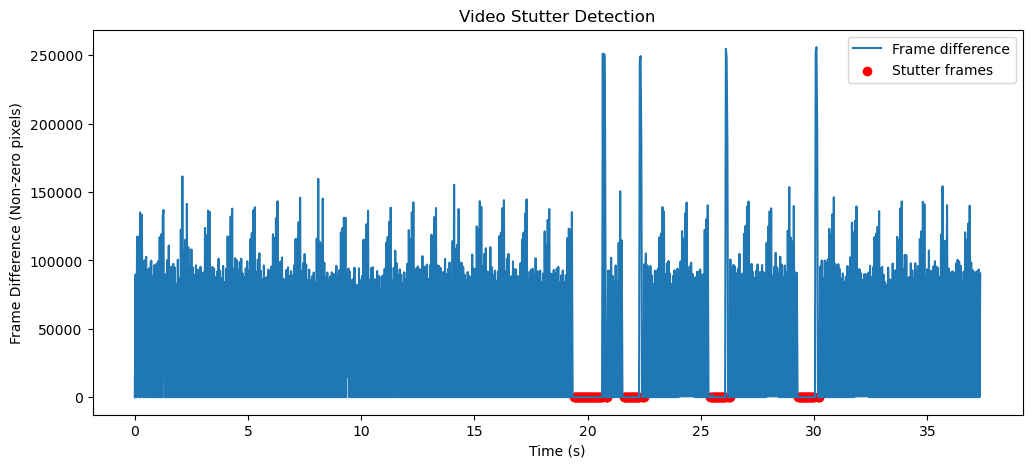

In [210]:
# -----------------------------------------------
# 実行例
# -----------------------------------------------
if __name__ == "__main__":
    # サンプルデバイス番号
    devices = [(0, "内蔵カメラ"), (1, "USBカメラ")]

    selected_device_number = launch_gui(devices)
    if selected_device_number is not None:
        frames, stutter_frames, actual_fps = start_capture(selected_device_number)
        plot_stutter(frames, stutter_frames)